In [8]:
import numpy as np
import pickle
import math
import keras
import time
from datetime import timedelta
import datetime
import pandas as pd
import random
from src import utils, trnvaltst_sigmoid_oned, TGCNN_layer, whole_model, whole_model_demographics, create_fake_patients, plot_figures
from early_stopping_cv import EarlyStopping
from tensorflow import keras
import tensorflow as tf
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, precision_score, roc_auc_score, recall_score
from csv import writer
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
print("tensorflow version:", tf. __version__)
tf.config.list_physical_devices()

tensorflow version: 2.10.1


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [9]:
no_LSTM = False # True = without LSTM
exponential_scaling = True # True = with exponential
L1_ablation = True # True = with L1 reg
L2_ablation = True # True = with L2 reg
variable_gamma = True
graph_reg_incl = True

num_of_runs = 1
    
weighted_loss = False # class weighted to deal with imbalance if True
no_timestamp = False # if no_timestamp = True then all values in 3-tensor = 1
activation_type = 'LeakyReLU' #'relu','gelu', 'LeakyReLU'
second_TGCNN_layer = True
demo = True
include_drugs = False

run_name='hip_1999_to_one_year_advance_model'

# strings for hyperparameter searching file
LSTM_str="LSTM excluded" if no_LSTM == True else "LSTM included"
exp_str = "exp excluded" if exponential_scaling == False else "exp included"
timestamp_str = "time elapsed = 1" if no_timestamp == True else "time elapsed"
weighted_loss_str = "weighted_loss" if weighted_loss ==True else "unweighted_loss"
L1_str = "L1 included" if L1_ablation == True else "L1 excluded"
L2_str = "L2 included" if L2_ablation == True else "L2 excluded"
second_layer_str = "Branched model" if second_TGCNN_layer == True else "Unbranched model"

In [10]:
if include_drugs:
    max_event_codes = 518
else:
    max_event_codes = 512
num_labels = 1 # number of outcomes -1 
hip_or_knee = 'hip'
class_weights = tf.compat.v2.constant([[0.5, 0.5]]) # 50:50 split for the class weights

# This would be where you would import your data instead of using the `create_fake_patient_df` function
    # Data to train the model on 
cv_patients = create_fake_patients.create_fake_patient_df(num_patients=500, max_events=100, max_nodes=512)
    # Data to test and relicibrate on
test_patients = create_fake_patients.create_fake_patient_df(num_patients=500, max_events=100, max_nodes=512)
    # Data to test the recalibrated model on
recal_test_patients = create_fake_patients.create_fake_patient_df(num_patients=500, max_events=100, max_nodes=512)

cv_patients

,user,indices,values,num_time_steps,gender,imd_quin,age_at_label_event,replace_type
0,1,"[[498, 267, 100], [452, 498, 99], [146, 452, 9...","[0.10698553921610354, 0.23820779563211558, 0.1...",67,1,1.0,54.0,none
1,2,"[[279, 457, 100], [469, 279, 99], [109, 469, 9...","[0.17706879885311166, 0.8003689994775978, 0.41...",28,1,5.0,77.0,hip
2,3,"[[485, 4, 100], [443, 485, 99], [358, 443, 98]...","[0.8005652457839029, 0.17394758077072703, 0.20...",74,1,3.0,87.0,hip
3,4,"[[52, 39, 100], [470, 52, 99], [137, 470, 98],...","[0.2442608878158028, 0.35704847938381834, 0.45...",25,0,3.0,58.0,none
4,5,"[[97, 275, 100], [464, 97, 99], [43, 464, 98],...","[0.8789104957692077, 0.02154575945852022, 0.50...",71,1,1.0,42.0,none
...,...,...,...,...,...,...,...,...
494,495,"[[147, 144, 100], [18, 147, 99], [138, 18, 98]...","[0.5650800372507623, 0.9609601102605303, 0.442...",26,0,1.0,60.0,hip
495,496,"[[470, 422, 100], [168, 470, 99], [3, 168, 98]...","[0.9353853269364591, 0.41733124822806567, 0.61...",46,1,3.0,81.0,none
496,497,"[[325, 341, 100], [70, 325, 99], [331, 70, 98]...","[0.9259711914462481, 0.010009328678985074, 0.5...",21,1,1.0,57.0,none
497,498,"[[185, 311, 100], [294, 185, 99]]","[0.040762192185835655, 0.677852179179024]",2,1,2.0,72.0,none


In [11]:
cv_sample_size = len(cv_patients)
test_sample_size = len(test_patients)
recal_test_sample_size = len(recal_test_patients)

# NOTE: num_time_steps isn't actually the number of time_steps it's the length of the values list (sometimes multiple Read codes will be reported in one visit)
# This is needed to create a sparse matrix

max_timesteps_cv = cv_patients['num_time_steps'].max() 
max_timesteps_test = test_patients['num_time_steps'].max()
max_timesteps_recal = recal_test_patients['num_time_steps'].max()
max_timesteps = max(max_timesteps_cv, max_timesteps_test, max_timesteps_recal)
max_timesteps
max_timesteps = max_timesteps + 1

In [12]:
cv_y = utils.get_labels_binary(cv_patients)
test_y = utils.get_labels_binary(test_patients)
recal_test_y = utils.get_labels_binary(recal_test_patients)

utils.check_group_sizes(cv_patients, test_patients, cv_y, test_y)

Number of people in the cv input data 499
Number of people in cv label data: 499
Number of people in the test input data 499
Number of people in test label data: 499
Number of patients in each class in cv set:
replace_type
hip     253
none    246
Name: count, dtype: int64

Number of patients in each class in test set:
replace_type
hip     267
none    232
Name: count, dtype: int64


#### Convert list of lists of event codes into Sparse Tensor

In [13]:
cv_input_matrices = utils.create_sparse_tensors(cv_sample_size, cv_patients, max_event_codes, max_timesteps, 'cv')
test_input_matrices = utils.create_sparse_tensors(test_sample_size, test_patients, max_event_codes, max_timesteps, 'test')
recal_test_input_matrices = utils.create_sparse_tensors(recal_test_sample_size, recal_test_patients, max_event_codes, max_timesteps, 'recal_test')

cv : converting from input matrices to SparseTensors
0/499 converted to SparseTensors 0.00%
test : converting from input matrices to SparseTensors
0/499 converted to SparseTensors 0.00%
recal_test : converting from input matrices to SparseTensors
0/499 converted to SparseTensors 0.00%


#### Hyperparameter tuning, model 5-fold-cv training and testing.

Run name: hip_1999_to_one_year_advance_model 1
Number of epochs: 20
Learning rate: 0.001
Number of 3D CNN filters: 32
Filter size: 6
Number of LSTM neurons: 64
Number of fully connected layers: 64
Dropout value: 0.8
Regularisation strength: 0.0005
****************************************
hip_1999_to_one_year_advance_model_split1 _find
normalised gamma [[-0.07826541]]
normalised gamma [[-0.12344459]]

Epoch 1/20
Gamma: -0.07779140025377274
Gamma 2: -0.11969728022813797

TRAINING METRICS:
Training AUC: 0.5108
Train loss 968.2770
Train calibration slope -0.4420
Train accuracy: 50.6364%


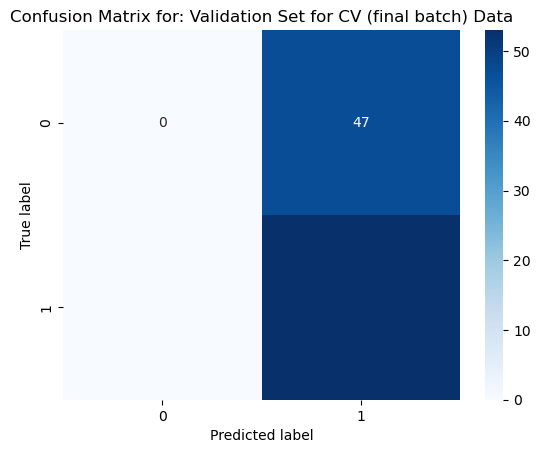

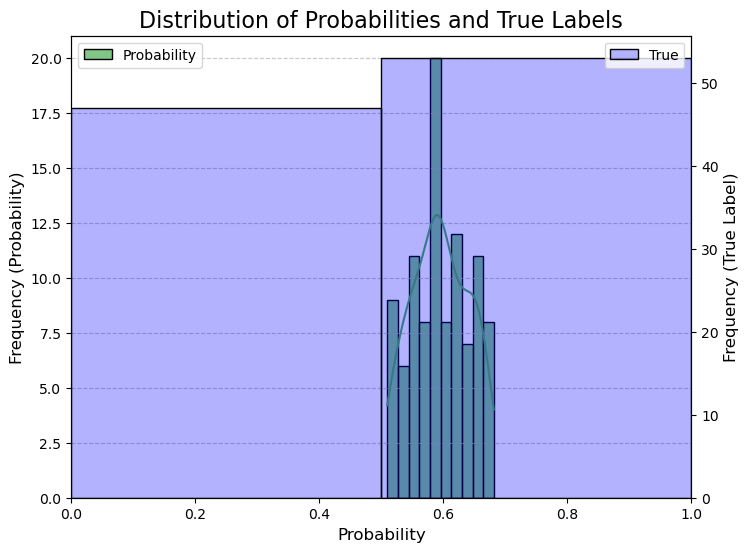

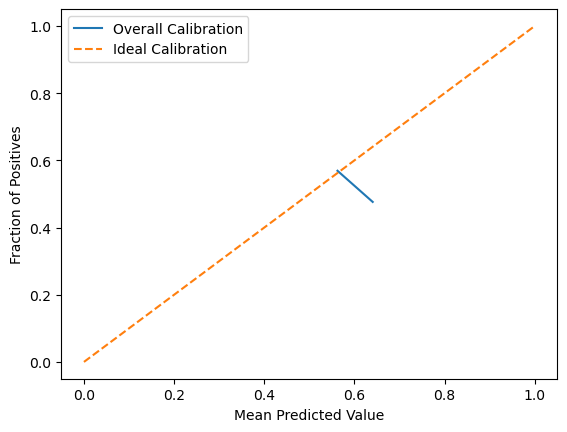


VALIDATION METRICS:
Validation AUC: 0.5000
Validation loss: 908.7468
Validation calibration slope: -1.1878
Validation accuracy: 53.0000%
Validation loss decreased (inf --> 908.746826).


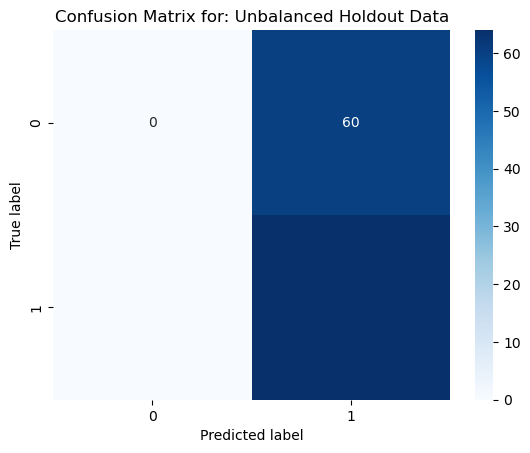

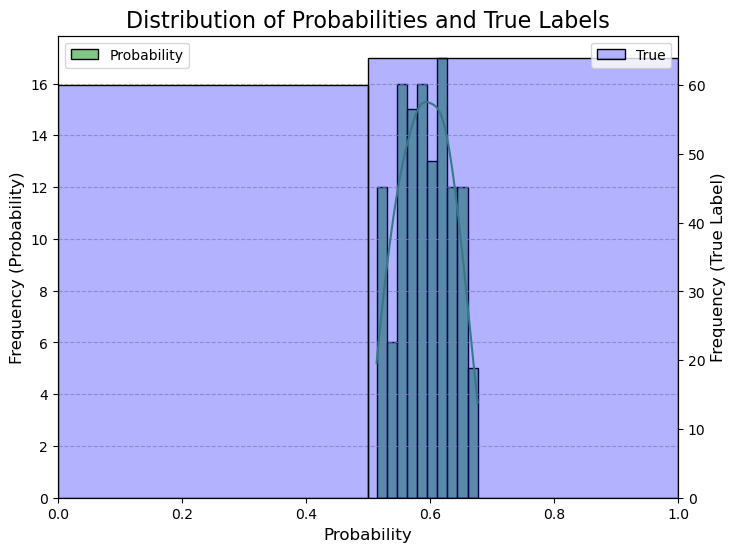

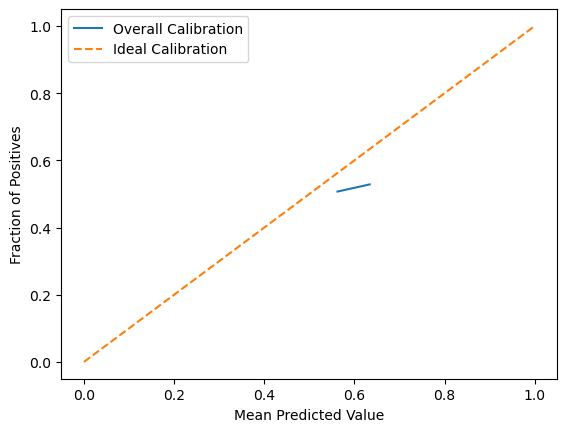


TEST/HOLDOUT METRICS:
Test individual AUC scores: 0.5000
Test calibration: -0.0227
Test accuracy: 53.5032%
Test Recall: 0.5350
Test Precision: 0.7534
Test F1: 0.3742
****************************************

Epoch 2/20
Gamma: -0.08041942119598389
Gamma 2: -0.11619816720485687

TRAINING METRICS:
Training AUC: 0.5175
Train loss 874.7899
Train calibration slope 0.6637
Train accuracy: 50.1212%


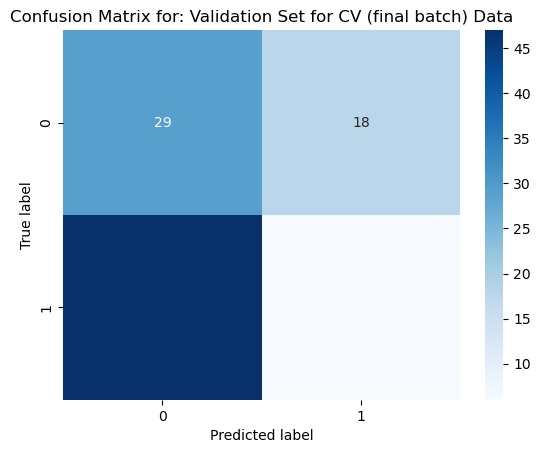

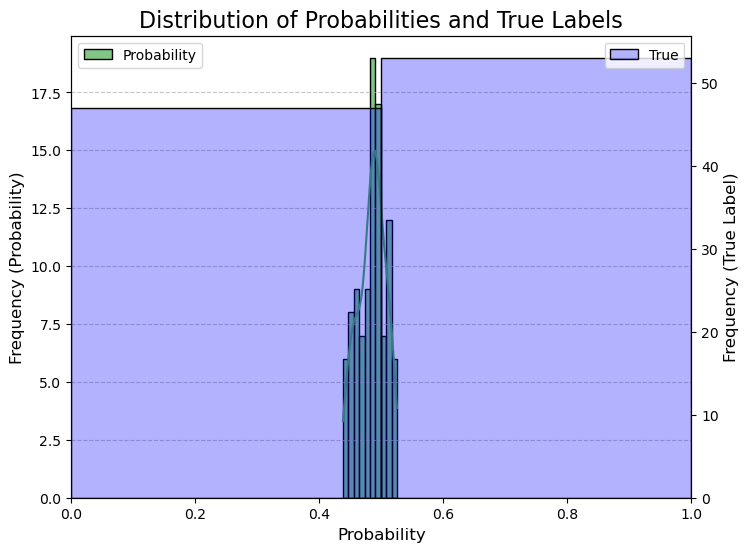

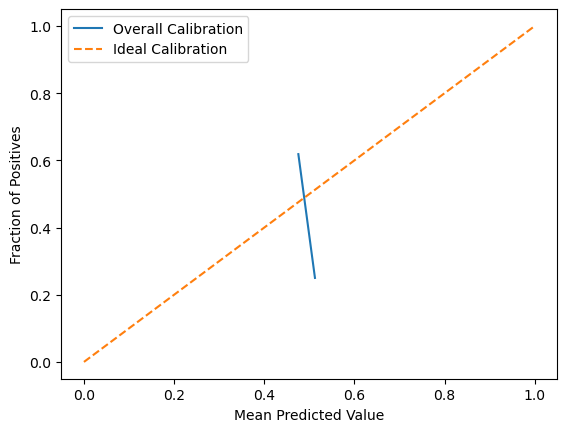


VALIDATION METRICS:
Validation AUC: 0.3651
Validation loss: 819.5638
Validation calibration slope: -9.9979
Validation accuracy: 35.0000%
Validation loss decreased (908.746826 --> 819.563782).

Epoch 3/20
Gamma: -0.08186089992523193
Gamma 2: -0.11327648162841797

TRAINING METRICS:
Training AUC: 0.5137
Train loss 788.1596
Train calibration slope 0.2508
Train accuracy: 50.8510%


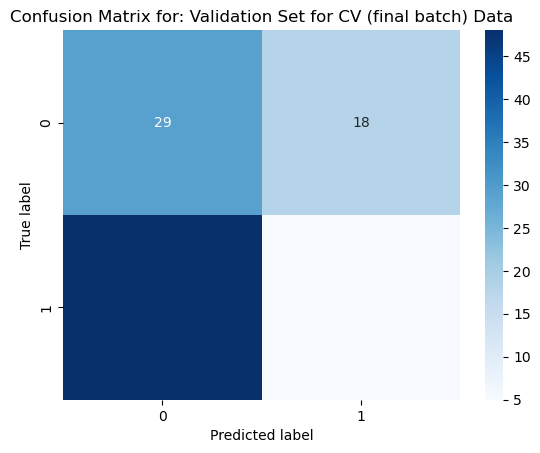

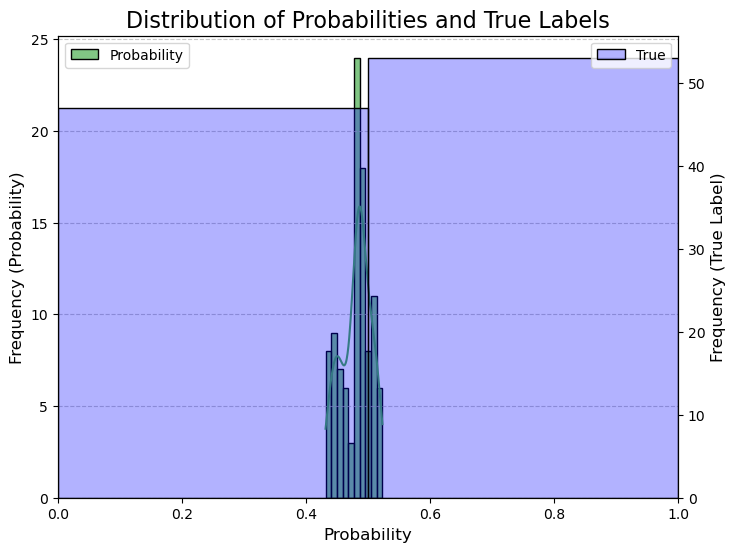

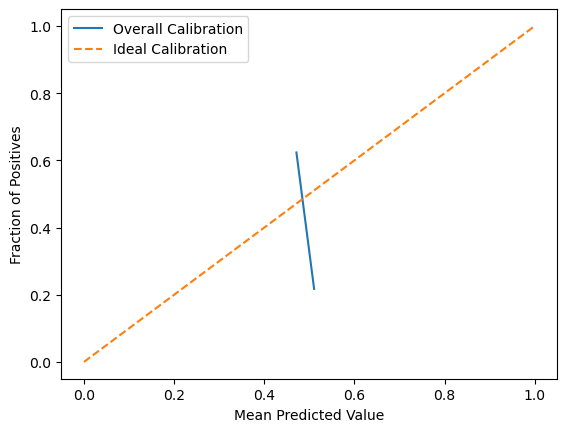


VALIDATION METRICS:
Validation AUC: 0.3557
Validation loss: 737.0688
Validation calibration slope: -10.3444
Validation accuracy: 34.0000%
Validation loss decreased (819.563782 --> 737.068787).

Epoch 4/20
Gamma: -0.08035533875226974
Gamma 2: -0.11065112054347992

TRAINING METRICS:
Training AUC: 0.5163
Train loss 708.0209
Train calibration slope 0.6740
Train accuracy: 53.1263%


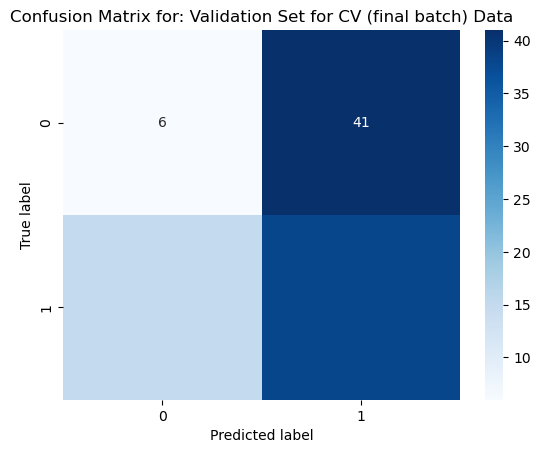

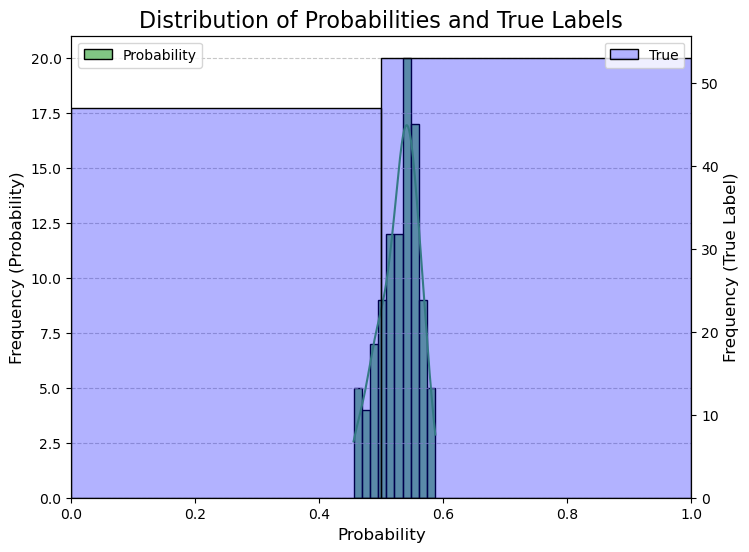

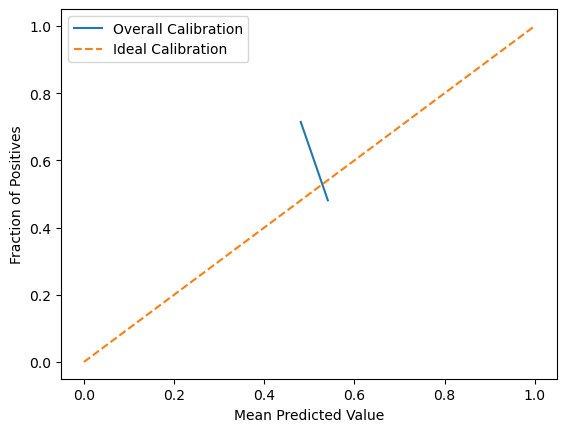


VALIDATION METRICS:
Validation AUC: 0.4223
Validation loss: 660.9327
Validation calibration slope: -3.8812
Validation accuracy: 44.0000%
Validation loss decreased (737.068787 --> 660.932739).

Epoch 5/20
Gamma: -0.07954739034175873
Gamma 2: -0.10926943272352219

TRAINING METRICS:
Training AUC: 0.5199
Train loss 634.0654
Train calibration slope 1.1111
Train accuracy: 51.6465%


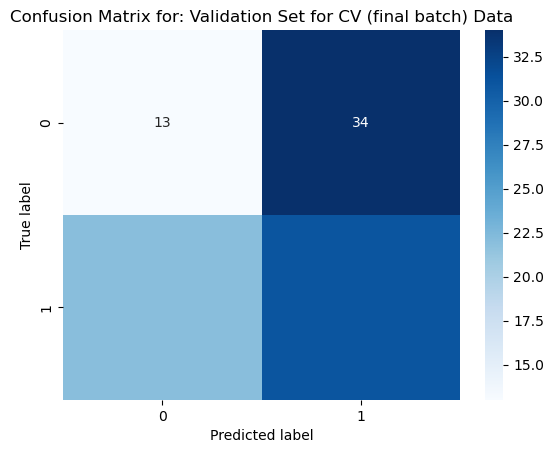

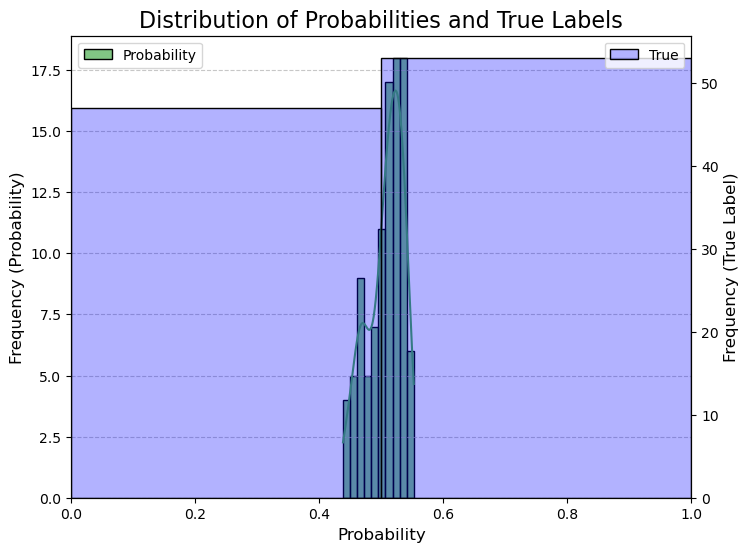

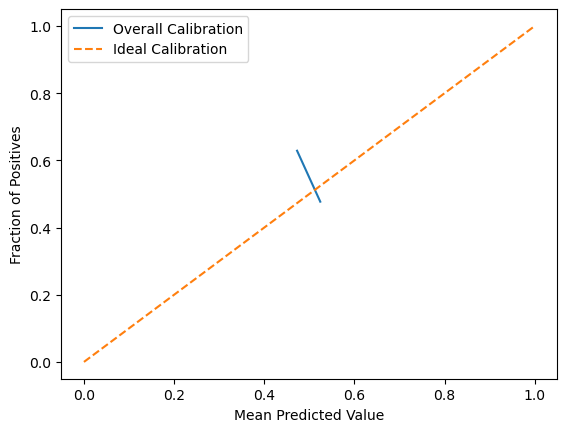


VALIDATION METRICS:
Validation AUC: 0.4308
Validation loss: 590.6098
Validation calibration slope: -2.9488
Validation accuracy: 44.0000%
Validation loss decreased (660.932739 --> 590.609802).

Epoch 6/20
Gamma: -0.07938650995492935
Gamma 2: -0.10789159685373306

TRAINING METRICS:
Training AUC: 0.6155
Train loss 565.8909
Train calibration slope 1.6575
Train accuracy: 60.6439%


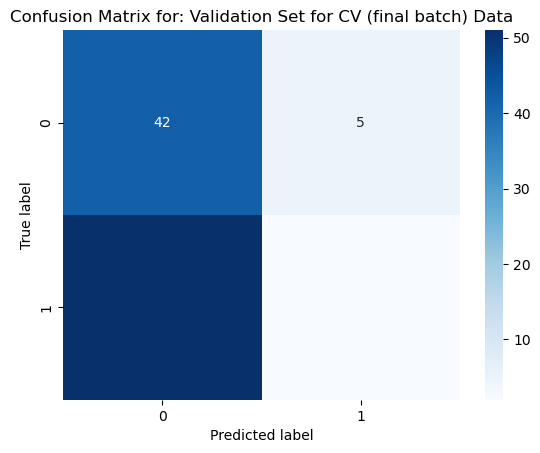

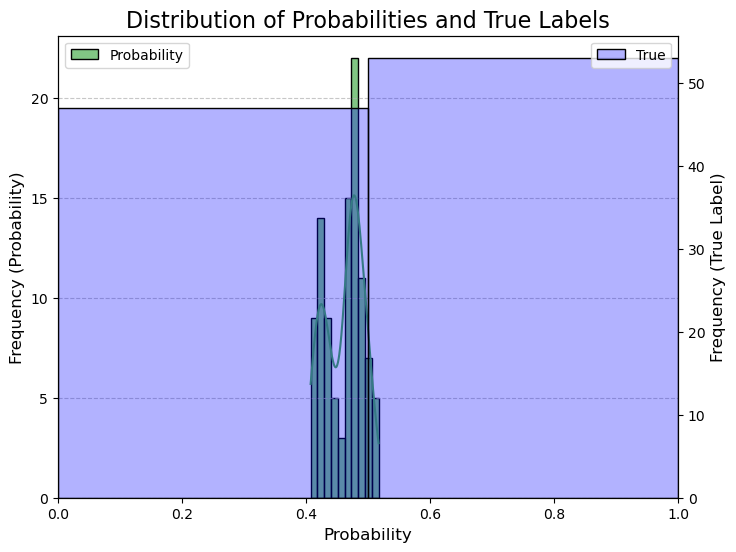

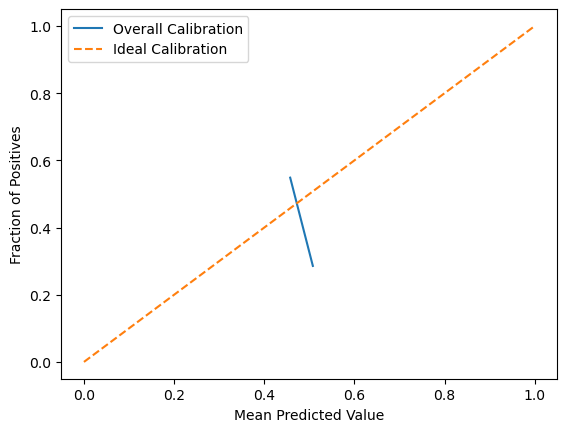


VALIDATION METRICS:
Validation AUC: 0.4657
Validation loss: 525.9127
Validation calibration slope: -5.2270
Validation accuracy: 44.0000%
Validation loss decreased (590.609802 --> 525.912720).

Epoch 7/20
Gamma: -0.07875405997037888
Gamma 2: -0.1060844361782074

TRAINING METRICS:
Training AUC: 0.6723
Train loss 503.1854
Train calibration slope 1.7731
Train accuracy: 67.4293%


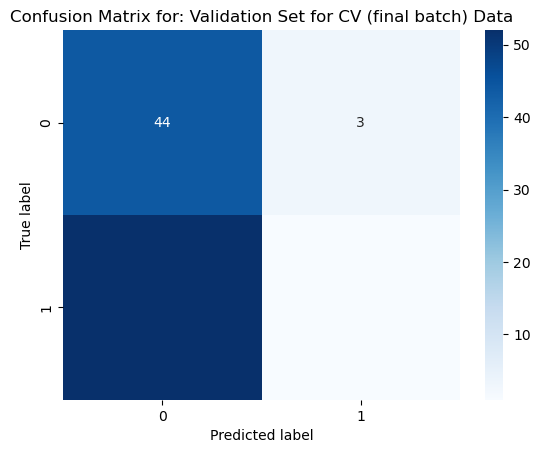

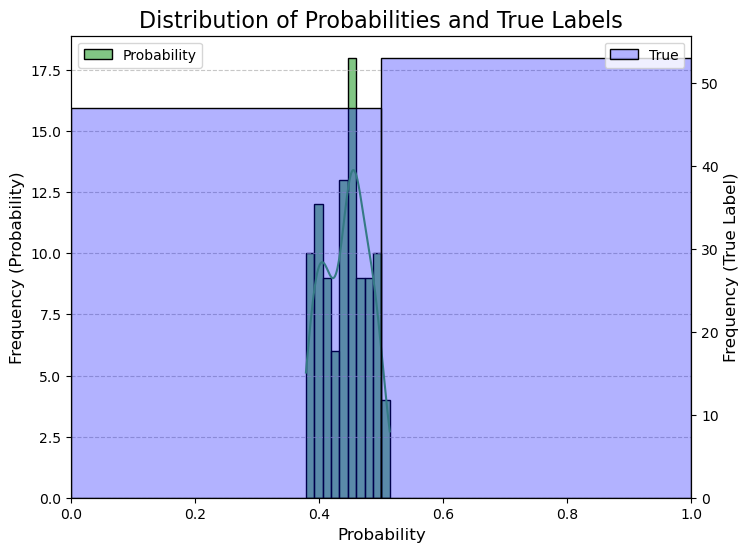

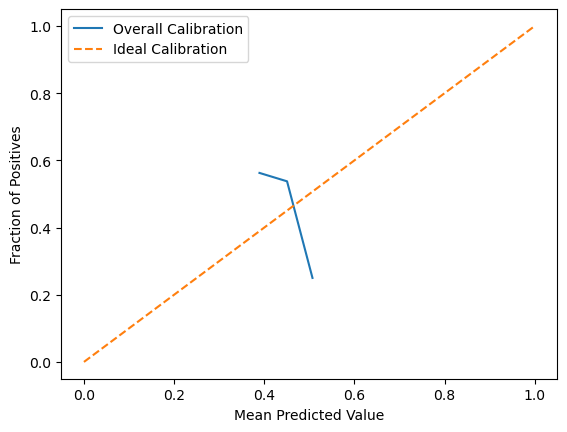


VALIDATION METRICS:
Validation AUC: 0.4775
Validation loss: 466.6368
Validation calibration slope: -2.6271
Validation accuracy: 45.0000%
Validation loss decreased (525.912720 --> 466.636841).

Epoch 8/20
Gamma: -0.07916607707738876
Gamma 2: -0.1039351150393486

TRAINING METRICS:
Training AUC: 0.6796
Train loss 445.7974
Train calibration slope 1.1044
Train accuracy: 68.1667%


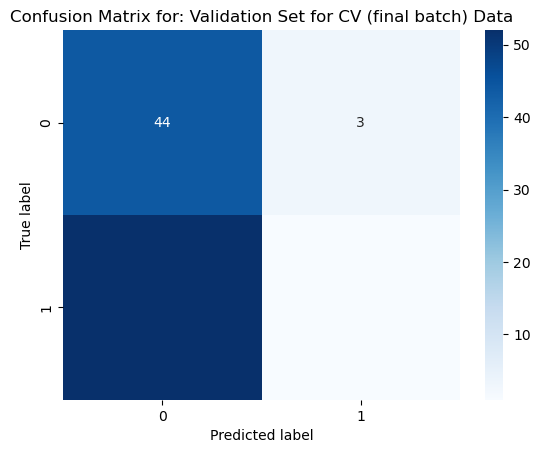

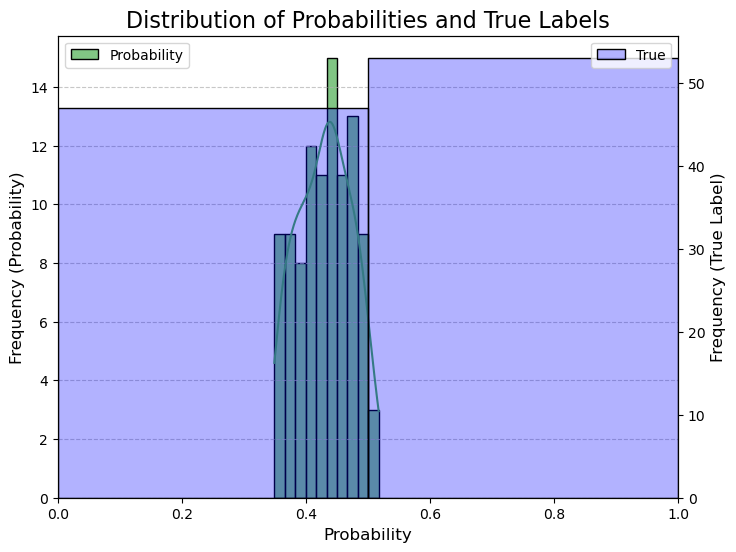

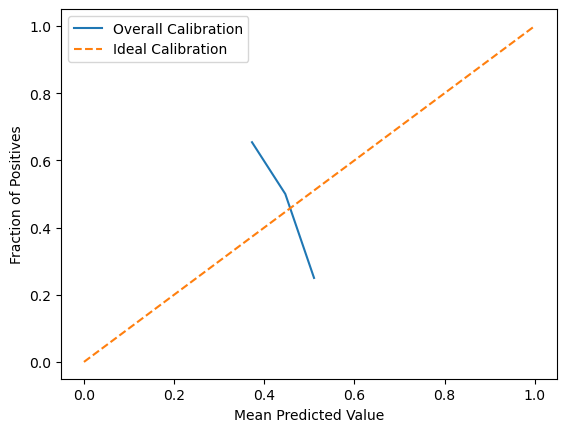


VALIDATION METRICS:
Validation AUC: 0.4775
Validation loss: 412.4716
Validation calibration slope: -2.9132
Validation accuracy: 45.0000%
Validation loss decreased (466.636841 --> 412.471558).

Epoch 9/20


KeyboardInterrupt: 

In [14]:
cv_size = int(round(cv_sample_size*0.2)) # 1/5th of cv data
holdout_size = len(test_patients) # this contains 10% of the controls + 7 cases for each of these controls

start_num = 1
for ran_search_num in range(start_num, start_num+num_of_runs):
    print('Run name:', run_name, ran_search_num)
    cv_indices = list(range(len(cv_input_matrices)))
    test_indices = list(range(len(test_input_matrices)))
    recal_test_indices = list(range(len(recal_test_input_matrices)))

    # Shuffle datasets to feed randomly into the model
    random.shuffle(cv_indices)
    random.shuffle(test_indices)
    random.shuffle(recal_test_indices)
    
    # split the cv data for cross validation
    cv_split1_indices = cv_indices[:cv_size]
    cv_split2_indices = cv_indices[cv_size:2*cv_size]
    cv_split3_indices = cv_indices[2*cv_size:3*cv_size]
    cv_split4_indices = cv_indices[3*cv_size:4*cv_size]
    cv_split5_indices = cv_indices[4*cv_size:5*cv_size]


    batch_size = 128 # choose a batch size

    batched_graphs_split1, batched_labels_split1, batched_cv_split1_indices = utils.batch_set(indice_set=cv_split1_indices, input_matrices=cv_input_matrices, 
                                                       labels=cv_y.to_numpy(), batchsize=batch_size)
    batched_graphs_split2, batched_labels_split2, batched_cv_split2_indices = utils.batch_set(indice_set=cv_split2_indices, input_matrices=cv_input_matrices, 
                                                       labels=cv_y.to_numpy(), batchsize=batch_size)
    batched_graphs_split3, batched_labels_split3, batched_cv_split3_indices = utils.batch_set(indice_set=cv_split3_indices, input_matrices=cv_input_matrices, 
                                                       labels=cv_y.to_numpy(), batchsize=batch_size)
    batched_graphs_split4, batched_labels_split4, batched_cv_split4_indices = utils.batch_set(indice_set=cv_split4_indices, input_matrices=cv_input_matrices, 
                                                       labels=cv_y.to_numpy(), batchsize=batch_size)
    batched_graphs_split5, batched_labels_split5, batched_cv_split5_indices = utils.batch_set(indice_set=cv_split5_indices, input_matrices=cv_input_matrices, 
                                                       labels=cv_y.to_numpy(), batchsize=batch_size)
    
    
    batched_graphs_holdout, batched_labels_holdout, batched_holdout_indices = utils.batch_set(indice_set=test_indices, input_matrices=test_input_matrices, 
                                                         labels=test_y.to_numpy(), batchsize=batch_size)
    labels_holdout = [item for sublist in batched_labels_holdout for item in sublist]
    
    batched_graphs_holdout2, batched_labels_holdout2, batched_holdout2_indices = utils.batch_set(indice_set=recal_test_indices, input_matrices=recal_test_input_matrices, 
                                                         labels=recal_test_y.to_numpy(), batchsize=batch_size)
    labels_holdout2 = [item for sublist in batched_labels_holdout2 for item in sublist]
    
   

    
    # Save the true labels for analysis later
    file_full_name_true = 'pred_proba_and_true/'+run_name+str(ran_search_num)+'_holdout1_true.npy'
    with open(file_full_name_true, 'wb') as f:
        np.save(f, labels_holdout)
        
    file_full_name_true2 = 'pred_proba_and_true/'+run_name+str(ran_search_num)+'_holdout2_true.npy'
    with open(file_full_name_true2, 'wb') as f:
        np.save(f, labels_holdout2)
    
    
    
    # split cv data into batches for training
    graphs_train1, graphs_train2, graphs_train3, graphs_train4, graphs_train5, graphs_test1, graphs_test2, \
    graphs_test3, graphs_test4, graphs_test5, labels_train1, labels_train2, labels_train3, labels_train4, \
    labels_train5, labels_test1, labels_test2, labels_test3, labels_test4, labels_test5, indices_train1, \
    indices_train2, indices_train3, indices_train4, indices_train5, indices_test1, indices_test2, indices_test3, \
    indices_test4, indices_test5, \
    = utils.get_cv_groups(batched_graphs_split1, batched_graphs_split2, batched_graphs_split3, batched_graphs_split4, 
                    batched_graphs_split5, batched_labels_split1, batched_labels_split2, batched_labels_split3, 
                    batched_labels_split4, batched_labels_split5, batched_cv_split1_indices, batched_cv_split2_indices, 
                    batched_cv_split3_indices, batched_cv_split4_indices, batched_cv_split5_indices)

    
    nepochs=20
    # Random hyperparameter selection
    lr = random.choice([0.001, 0.005, 0.0001]) # initial learning rate

    out_chans = random.choice([8, 16, 32]) # number of filters
    filter_size = random.choice([3, 4, 6]) # number of time steps/ filter size
    if no_LSTM:
        lstm_h = 0
    else:
        lstm_h = random.choice([16, 32, 64, 128, 256]) # number of LSTM neurons
    linear_size = random.choice([64, 128]) # linear layer output size
    drop_val = random.choice([0.5, 0.6, 0.7, 0.8, 0.9])
    reg_strength = random.choice([1e-2, 5e-2, 1e-3, 5e-3, 1e-4, 5e-4, 1e-5])
    graph_reg_strength = 1e1
    

    print(f"Number of epochs: {nepochs}")
    print(f"Learning rate: {lr}")
    print(f"Number of 3D CNN filters: {out_chans}")
    print(f"Filter size: {filter_size}")
    print(f"Number of LSTM neurons: {lstm_h}")
    print(f"Number of fully connected layers: {linear_size}")
    print(f"Dropout value: {drop_val}")
    print(f"Regularisation strength: {reg_strength}")
    print("*"*40)
    

    #############################################
    ####### FOR LOOP FOR CV HERE  ###############
    #############################################
    
    cv_accuracy, cv_auc, cv_cal_slope = [], [], []
    best_metric = 0
    for split in range(0, 5):
        run_split_name = run_name +"_split" + str(split+1)
        print(run_split_name, "_find")
        
        if demo:
            model = whole_model_demographics.TGCNN_Model(num_filters=out_chans, num_nodes=max_event_codes, num_time_steps=max_timesteps, 
                            filter_size=filter_size, variable_gamma=variable_gamma, 
                            exponential_scaling=exponential_scaling, dropout_rate=drop_val, lstm_units=lstm_h,
                            fcl1_units=linear_size, LSTM_ablation=no_LSTM, stride=1, activation_type=activation_type, 
                            no_timestamp=no_timestamp, second_TGCNN_layer=second_TGCNN_layer, num_labels=num_labels)
        else:
            model = whole_model.TGCNN_Model(num_filters=out_chans, num_nodes=max_event_codes, num_time_steps=max_timesteps, 
                            filter_size=filter_size, variable_gamma=variable_gamma, 
                            exponential_scaling=exponential_scaling, dropout_rate=drop_val, lstm_units=lstm_h,
                            fcl1_units=linear_size, LSTM_ablation=no_LSTM, stride=1, activation_type=activation_type, 
                            no_timestamp=no_timestamp, second_TGCNN_layer=second_TGCNN_layer, num_labels=num_labels)
    
        early_stopping = EarlyStopping(patience=5, verbose=True)


        lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate=lr,
            decay_steps=1000,
            decay_rate=0.9)

        optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
        
        if split+1 == 1:
            batched_graphs_trn, batched_labels_trn = graphs_train1, labels_train1
            batched_graphs_val, batched_labels_val = graphs_test1, labels_test1
            train_indices = indices_train1
            test_indices = indices_test1
            
        elif split+1 == 2:
            batched_graphs_trn, batched_labels_trn = graphs_train2, labels_train2
            batched_graphs_val, batched_labels_val = graphs_test2, labels_test2
            train_indices = indices_train2
            test_indices = indices_test2
            
        elif split+1 == 3:
            batched_graphs_trn, batched_labels_trn = graphs_train3, labels_train3
            batched_graphs_val, batched_labels_val = graphs_test3, labels_test3
            train_indices = indices_train3
            test_indices = indices_test3
            
        elif split+1 == 4:
            batched_graphs_trn, batched_labels_trn = graphs_train4, labels_train4
            batched_graphs_val, batched_labels_val = graphs_test4, labels_test4
            train_indices = indices_train4
            test_indices = indices_test4
            
        elif split+1 == 5:
            batched_graphs_trn, batched_labels_trn = graphs_train5, labels_train5
            batched_graphs_val, batched_labels_val = graphs_test5, labels_test5
            train_indices = indices_train5
            test_indices = indices_test5
            
        
        start_time = time.monotonic()

        train_loss_epochs, train_acc_epochs, train_prec_epochs, train_recall_epochs, train_f1_epochs, train_auc_epochs = [],[],[],[],[],[]
        train_indiv_acc_epochs, train_indiv_prec_epochs, train_indiv_recall_epochs, train_indiv_f1_epochs, train_indiv_auc_epochs = [],[],[],[],[]
        val_loss_epochs, val_acc_epochs, val_prec_epochs, val_recall_epochs, val_f1_epochs, val_auc_epochs = [],[],[],[],[],[]
        val_indiv_acc_epochs, val_indiv_prec_epochs, val_indiv_recall_epochs, val_indiv_f1_epochs, val_indiv_auc_epochs = [],[],[],[],[]
        
        for epoch in range(nepochs):
            print(f"\nEpoch {epoch+1}/{nepochs}")

            # Iterate over the batches of the dataset.
            train_loss_list, train_acc_list, train_prec_list, train_recall_list, train_f1_list, train_auc_list = [],[],[],[],[],[]
            train_cal_slope_list = []
            train_all_classes_prec_list, train_all_classes_recall_list, train_all_classes_f1_list, train_all_classes_auc_list = [],[],[],[] # lists of list

            for x_batch_train, y_batch_train, train_indices_list in zip(batched_graphs_trn, batched_labels_trn, train_indices):
            # need to get one list at a time from the list of lists
                    
                trn_demo_vals, trn_demo_list = utils.convert_demos_to_tensor(cv_patients, train_indices_list, demo)
                
                if demo == False:
                    trn_demo_vals = None
                
                y_batch_train=np.array(y_batch_train)
                trn_logits, trn_loss, trn_acc, trn_prec, trn_recall, trn_auc, trn_f1, \
                indiv_trn_prec, indiv_trn_recall, indiv_trn_auc, indiv_trn_f1, trn_cal_slope, model,\
                = trnvaltst_sigmoid_oned.train_step(x_batch_train, y_batch_train, trn_demo_vals,
                                                        reg_strength,class_weights,model,L1_ablation,L2_ablation, 
                                                       graph_reg_strength, graph_reg_incl, exponential_scaling,
                                                       weighted_loss, variable_gamma, optimizer, demo)

                train_loss_list.append(trn_loss)
                train_cal_slope_list.append(trn_cal_slope)
                train_acc_list.append(trn_acc)

                train_all_classes_prec_list.append(trn_prec)
                train_prec_list.append(indiv_trn_prec)

                train_all_classes_recall_list.append(trn_recall)
                train_recall_list.append(indiv_trn_recall)

                train_all_classes_auc_list.append(trn_auc)
                train_auc_list.append(indiv_trn_auc)

                train_all_classes_f1_list.append(trn_f1)
                train_f1_list.append(indiv_trn_f1)

            if variable_gamma and (exponential_scaling==True):
                gamma_val = float(model.tg_conv_layer1.gammat.numpy())
                print("Gamma:", gamma_val)
                if second_TGCNN_layer:
                    gamma_val2 = float(model.tg_conv_layer2.gammat.numpy())
                    print("Gamma 2:", gamma_val2)

            # get the average metric score for each class for this ONE epoch using the batch list metrics
            train_prec_indiv_ave = utils.average_of_list_of_lists(train_all_classes_prec_list)
            train_recall_indiv_ave = utils.average_of_list_of_lists(train_all_classes_recall_list)
            train_f1_indiv_ave = utils.average_of_list_of_lists(train_all_classes_f1_list) # ave F1 score for each class
            train_auc_indiv_ave = utils.average_of_list_of_lists(train_all_classes_auc_list)

            print("\nTRAINING METRICS:")
            print(f"Training AUC: {np.mean(train_auc_list):.4f}")
            print(f"Train loss {np.mean(train_loss_list):.4f}")
            print(f"Train calibration slope {np.mean(train_cal_slope_list):.4f}")
            print(f"Train accuracy: {np.mean(train_acc_list) :.4%}")


            # Validation loop
            val_loss_list, val_acc_list,  val_prec_list, val_recall_list, val_auc_list, val_f1_list = [],[],[],[],[],[]
            val_cal_slope_list = []
            val_all_classes_acc_list, val_all_classes_prec_list, val_all_classes_recall_list, val_all_classes_f1_list, val_all_classes_auc_list = [],[],[],[],[]
            for x_batch_val, y_batch_val, test_indices_list in zip(batched_graphs_val, batched_labels_val, test_indices):
                
                test_demo_vals, test_demo_list = utils.convert_demos_to_tensor(cv_patients, test_indices_list, demo)                
                
                if demo == False:
                    test_demo_vals = None
                
                val_logits, val_loss, val_acc, val_prec, val_recall, val_auc, val_f1, \
                indiv_val_prec, indiv_val_recall, indiv_val_auc, indiv_val_f1, val_cal_slope, model, \
                = trnvaltst_sigmoid_oned.val_step(x_batch_val, y_batch_val, test_demo_vals, reg_strength, 
                                                  class_weights, model, L1_ablation, L2_ablation, 
                                                  graph_reg_strength, graph_reg_incl, weighted_loss, demo)

                val_loss_list.append(val_loss)
                val_cal_slope_list.append(val_cal_slope)

                val_acc_list.append(val_acc)

                val_prec_list.append(val_prec)
                val_all_classes_prec_list.append(indiv_val_prec)

                val_recall_list.append(val_recall) 
                val_all_classes_recall_list.append(indiv_val_recall)

                val_auc_list.append(val_auc)
                val_all_classes_auc_list.append(indiv_val_auc)

                val_f1_list.append(val_f1)
                val_all_classes_f1_list.append(indiv_val_f1)
            
            #plot_figures.draw_confusion_mat(y_batch_val, val_logits, ['none','hip'], run_name=None, ran_search_num=1111, data_type="V")
            #plot_figures.draw_calibration_curve(y_batch_val, val_logits, run_name=None, ran_search_num=1111)
            
            
            val_prec_indiv_ave = utils.average_of_list_of_lists(val_all_classes_prec_list)
            val_recall_indiv_ave = utils.average_of_list_of_lists(val_all_classes_recall_list)
            val_f1_indiv_ave = utils.average_of_list_of_lists(val_all_classes_f1_list) # ave F1 score for each class
            val_auc_indiv_ave = utils.average_of_list_of_lists(val_all_classes_auc_list)
            
            # Saves the logits if the AUC improves
            improved_metric = False
            if np.mean(val_auc_list) > best_metric:
                best_metric = np.mean(val_auc_list)
                improved_metric = True

            print("\nVALIDATION METRICS:")
            print(f"Validation AUC: {np.mean(val_auc_list):.4f}")
            print(f"Validation loss: {np.mean(val_loss_list):.4f}")
            print(f"Validation calibration slope: {np.mean(val_cal_slope_list):.4f}")
            print(f"Validation accuracy: {np.mean(val_acc_list) :.4%}")



            print("="*50)

            # get the average metric from ONE epoch
            ave_epoch_train_loss, ave_epoch_train_acc, ave_epoch_train_auc, ave_epoch_train_prec, ave_epoch_train_recall, ave_epoch_train_f1 = np.mean(train_loss_list), np.mean(train_acc_list), np.mean(train_auc_list), np.mean(train_prec_list), np.mean(train_recall_list), np.mean(train_f1_list)
            ave_epoch_val_loss, ave_epoch_val_acc, ave_epoch_val_auc, ave_epoch_val_prec, ave_epoch_val_recall, ave_epoch_val_f1 = np.mean(val_loss_list), np.mean(val_acc_list), np.mean(val_auc_list), np.mean(val_prec_list), np.mean(val_recall_list), np.mean(val_f1_list)        


            #print(optimizer.get_config())

            # save the average (from one epoch) to the list of ALL epochs
            utils.metric_save(ave_epoch_train_loss, train_loss_epochs, ave_epoch_val_loss, val_loss_epochs) #losses
            utils.metric_save(ave_epoch_train_acc, train_acc_epochs, ave_epoch_val_acc, val_acc_epochs) # acc
            utils.metric_save(ave_epoch_train_auc, train_auc_epochs, ave_epoch_val_auc, val_auc_epochs) # auc        
            utils.metric_save(ave_epoch_train_prec, train_prec_epochs, ave_epoch_val_prec, val_prec_epochs) # prec
            utils.metric_save(ave_epoch_train_recall, train_recall_epochs, ave_epoch_val_recall, val_recall_epochs) # recall
            utils.metric_save(ave_epoch_train_f1, train_f1_epochs, ave_epoch_val_f1, val_f1_epochs) #f1

            # save the average from one epoch to the list of ALL epochs for each individual class
            utils.metric_save(train_auc_indiv_ave, train_indiv_auc_epochs, val_auc_indiv_ave, val_indiv_auc_epochs)
            utils.metric_save(train_prec_indiv_ave, train_indiv_prec_epochs, val_prec_indiv_ave, val_indiv_prec_epochs)
            utils.metric_save(train_recall_indiv_ave, train_indiv_recall_epochs, val_recall_indiv_ave, val_indiv_recall_epochs)
            utils.metric_save(train_f1_indiv_ave, train_indiv_f1_epochs, val_f1_indiv_ave, val_indiv_f1_epochs)


            early_stopping_metric = val_loss_list # metric that is used to determine if the model should stop training
            early_stopping(np.mean(early_stopping_metric), train_loss_list, val_loss_list, 
                           train_cal_slope_list, val_cal_slope_list,
                           train_acc_list, val_acc_list,  
                           train_auc_list, val_auc_list,
                           train_auc_indiv_ave, val_auc_indiv_ave,
                           train_prec_list, val_prec_list,
                           train_prec_indiv_ave, val_prec_indiv_ave,
                           train_recall_list, val_recall_list,
                           train_recall_indiv_ave, val_recall_indiv_ave,
                           train_f1_list, val_f1_list,
                           train_f1_indiv_ave, val_f1_indiv_ave, 
                           model, run_name+str(ran_search_num),
                           batched_graphs_holdout, batched_labels_holdout, batched_holdout_indices,
                           batched_graphs_holdout2, batched_labels_holdout2, batched_holdout2_indices,
                           reg_strength,
                           class_weights, L1_ablation, L2_ablation, graph_reg_strength, graph_reg_incl, weighted_loss, 
                           improved_metric, test_patients, recal_test_patients, 
                           demo)

            if early_stopping.checkpoint_made:

                checkpoint_train_loss, checkpoint_val_loss, \
                checkpoint_train_cal_slope, checkpoint_val_cal_slope, \
                checkpoint_train_acc, checkpoint_val_acc, \
                checkpoint_train_auc, checkpoint_val_auc, \
                checkpoint_train_auc_indiv, checkpoint_val_auc_indiv, \
                checkpoint_train_prec, checkpoint_val_prec,  \
                checkpoint_train_prec_indiv, checkpoint_val_prec_indiv, \
                checkpoint_train_recall, checkpoint_val_recall, \
                checkpoint_train_recall_indiv, checkpoint_val_recall_indiv, \
                checkpoint_train_f1, checkpoint_val_f1, \
                checkpoint_train_f1_indiv, checkpoint_val_f1_indiv = early_stopping.print_checkpoint_metric(train_loss_list, 
                                                                            val_loss_list, 
                                                                            train_cal_slope_list, val_cal_slope_list,
                                                                            train_acc_list, val_acc_list, 
                                                                            train_auc_list, val_auc_list, 
                                                                            train_auc_indiv_ave, val_auc_indiv_ave,
                                                                            train_prec_list, val_prec_list,
                                                                            train_prec_indiv_ave, val_prec_indiv_ave,                                        
                                                                            train_recall_list, val_recall_list,
                                                                            train_recall_indiv_ave, val_recall_indiv_ave,                                        
                                                                            train_f1_list, val_f1_list,
                                                                            train_f1_indiv_ave, val_f1_indiv_ave)


            if early_stopping.early_stop:
                print("Early stopping")
                break



        if variable_gamma and (exponential_scaling==True):
            gamma_val = float(model.tg_conv_layer1.gammat.numpy())
            print("Gamma:", gamma_val)
            if second_TGCNN_layer:
                gamma_val2 = float(model.tg_conv_layer2.gammat.numpy())
                print("Gamma 2:", gamma_val2)
                
        else:
            gamma_val = 'N/A'

        end_time = time.monotonic()
        time_taken = timedelta(seconds=end_time - start_time)

        list_for_csv = [run_split_name+"_"+str(ran_search_num), nepochs, epoch+1, str(time_taken), lr, out_chans, filter_size, 
                        lstm_h, reg_strength,
                       linear_size, drop_val, batch_size,

                        min(train_loss_epochs), max(train_loss_epochs), min(val_loss_epochs), 
                        max(val_loss_epochs), checkpoint_train_loss, checkpoint_val_loss,                    

                        min(train_auc_epochs), max(train_auc_epochs), min(val_auc_epochs), 
                        max(val_auc_epochs), checkpoint_train_auc, checkpoint_val_auc,
                        checkpoint_train_auc_indiv, checkpoint_val_auc_indiv,                    

                        min(train_acc_epochs), max(train_acc_epochs), min(val_acc_epochs), 
                        max(val_acc_epochs), checkpoint_train_acc, checkpoint_val_acc,

                        min(train_prec_epochs), max(train_prec_epochs), min(val_prec_epochs), 
                        max(val_prec_epochs), checkpoint_train_prec, checkpoint_val_prec,   
                        checkpoint_train_prec_indiv, checkpoint_val_prec_indiv,

                        min(train_recall_epochs), max(train_recall_epochs), min(val_recall_epochs), 
                        max(val_recall_epochs), checkpoint_train_recall, checkpoint_val_recall, 
                        checkpoint_train_recall_indiv, checkpoint_val_recall_indiv, 

                        min(train_f1_epochs), max(train_f1_epochs), min(val_f1_epochs), 
                        max(val_f1_epochs), checkpoint_train_f1, checkpoint_val_f1, 
                        checkpoint_train_f1_indiv, checkpoint_val_f1_indiv,

                        gamma_val, 
                        checkpoint_train_cal_slope, checkpoint_val_cal_slope,
                        activation_type, LSTM_str, exp_str, timestamp_str, weighted_loss_str, L1_str, L2_str,
                        second_layer_str]



        with open('results/cross_validation_results.csv', 'a', newline='') as f_object:
            writer_object = writer(f_object)
            writer_object.writerow(list_for_csv)
            f_object.close()



        print("\nCHECKPOINTED RESULTS")
        print(f"Train loss: {checkpoint_train_loss:.4f}") # average loss from the epoch
        print(f"Train AUC: {checkpoint_train_auc:.4%}\n")
        print(f"Val loss: {checkpoint_val_loss:.4f}") # average loss from the epoch
        print(f"Val AUC: {checkpoint_val_auc:.4%}\n")

        print("="*50)
        print("="*50)
        
        cv_accuracy.append(checkpoint_val_acc)
        cv_auc.append(checkpoint_val_auc)
        cv_cal_slope.append(checkpoint_val_cal_slope)
        
    print(f"5-fold CV Accuracy on (Validation Set): {np.mean(cv_accuracy):.4f} +/- {np.std(cv_accuracy):.4f}")
    print(f"5-fold CV AUC on (Validation Set): {np.mean(cv_auc):.4f} +/- {np.std(cv_auc):.4f}")
    print(f"5-fold CV Calibration Slope (Validation Set): {np.mean(cv_cal_slope):.4f} +/- {np.std(cv_cal_slope):.4f}")
    print("*"*100)
        
    class_names = ['none', 'hip']
#     plot_figures.plot_loss_curve(train_loss = train_loss_epochs, val_loss = val_loss_epochs, test_lost = test_loss_epochs, 
#                     run_name=run_split_name, ran_search_num=ran_search_num)


    # open the proba file and then plot the figures for the test data
    # The model is tested during early stopping
    with open('pred_proba_and_true/'+run_name+str(ran_search_num)+'_holdout1_proba.npy', 'rb') as f:
        test_logits = np.load(f)

    #plot_figures.draw_confusion_mat(labels_holdout, test_logits, class_names, run_name, ran_search_num)
    #plot_figures.draw_calibration_curve(labels_holdout, test_logits, run_name, ran_search_num)

In [ ]:
model.tg_conv_layer1.trainable_weights

: 

In [ ]:
model.outputs

In [ ]:
model.summary()